<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2024-2/blob/main/DL_day10/10_2_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with Deep Learning Models

You will now practice using deep learning models(Transformer, LSTM) to predict future values using past values. For your assignment, please change parameters, model structures and apply new model to shampoo data.

Reference:
* https://github.com/hee9joon/Univariate-Time-Series-Prediction-using-Deep-Learning.   
*  https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## Download Dataset

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2024-08-28 03:51:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2024-08-28 03:51:34 (22.6 MB/s) - ‘shampoo.csv’ saved [519/519]



In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-08-28 03:51:36--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-08-28 03:51:36 (32.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

## Data Plot

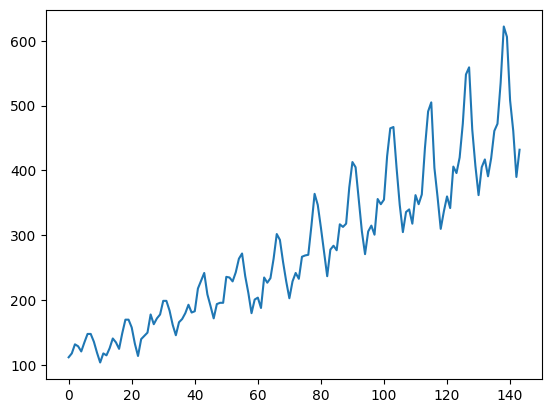

In [4]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [5]:
sc = StandardScaler()
seq_length = 4

test_size = 20
train_size = len(training_set) - seq_length - 20

train_data = sc.fit_transform(training_set[:-test_size])
test_data = sc.transform(training_set[-test_size:])

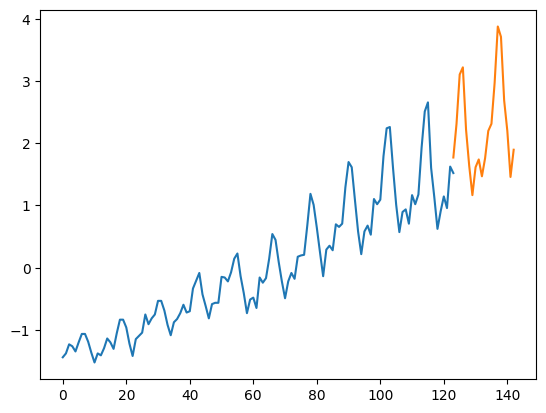

In [6]:
plt.plot(np.arange(124),train_data)
plt.plot(np.arange(20)+123,test_data)

In [7]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [8]:
normalized_data = np.concatenate([train_data, test_data])
x, y = sliding_windows(normalized_data, seq_length)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:-test_size])))
trainY = Variable(torch.Tensor(np.array(y[:-test_size])))

testX = Variable(torch.Tensor(np.array(x[-test_size:])))
testY = Variable(torch.Tensor(np.array(y[-test_size:])))

## Model

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()
        self.input_dim = input_dim
        self.n_heads = 4
        self.outlinear = nn.Linear(input_dim,input_dim)
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten(start_dim=-2)
    def forward(self, q, k, v):
        B, L = q.shape
        query = q.view(B, L//self.n_heads, self.n_heads)
        key = k.view(B, L//self.n_heads, self.n_heads)
        value = v.view(B, L//self.n_heads, self.n_heads)
        scale = 1. / 2
        scores = torch.einsum("ble,bse->bls",query,key)
        A = torch.softmax(scale * scores, dim=-1)
        #A = self.dropout(A)
        V = torch.einsum("bls,bsd->bld", A, value)
        out = self.flatten(V)
        return out#self.outlinear(out) ##

class EncoderBlock(nn.Module):
    def __init__(self, input_dim):
        super(EncoderBlock, self).__init__()
        self.input_dim = input_dim

        self.ffn = nn.Sequential(nn.Linear(self.input_dim, 2*self.input_dim),
                        nn.GELU(),
                        nn.Dropout(0.1),
                        nn.Linear(2*self.input_dim, self.input_dim))

        self.layernorm = nn.LayerNorm(self.input_dim)
        self.dropout = nn.Dropout(0.1)
        self.attn = AttentionBlock(self.input_dim)

    def forward(self, x):

        y = self.attn(x,x,x)
        x = x + self.dropout(y)
        x = self.layernorm(x)

        y = self.ffn(x)
        x = x + self.dropout(y)
        y = self.layernorm(x)

        return y

class Transformer(nn.Module):
    def __init__(self, input_dim, emb_dim, out_dim, num_encoder):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, emb_dim, bias=True)
        self.encoder_layers = nn.ModuleList([])
        for i in range(num_encoder):
            self.encoder_layers.append(EncoderBlock(emb_dim))
        self.output_layer = nn.Linear(emb_dim, out_dim, bias=True)
    def forward(self, x):
        mean = x.mean(dim=1,keepdim=True)
        std = x.std(dim=1,keepdim=True)
        x = (x-mean)/std
        x = self.input_layer(x)
        for l in self.encoder_layers:
            x = l(x)
        x = self.output_layer(x)
        x = x*std+mean
        return x

## Training

In [11]:
num_epochs = 5000
learning_rate = 0.0001

input_size = 4
embed_size = 16
num_layers = 3

output_size = 1

best_loss = 10
best_model = None

model = Transformer(input_size, embed_size, output_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX[:,:,0])
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 50 == 0:
      model.eval()
      outputs = model(testX[:,:,0])
      loss = criterion(outputs, testY)
      model.train()
      if loss.item()<best_loss:
        best_loss = loss.item()
        best_model = model
      if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.07503
Epoch: 500, loss: 0.23207
Epoch: 1000, loss: 0.18093
Epoch: 1500, loss: 0.14616
Epoch: 2000, loss: 0.14115
Epoch: 2500, loss: 0.15131
Epoch: 3000, loss: 0.19258
Epoch: 3500, loss: 0.20816
Epoch: 4000, loss: 0.20817
Epoch: 4500, loss: 0.20867


## Testing for Airplane Passengers Dataset

Best Loss: 0.13936787843704224


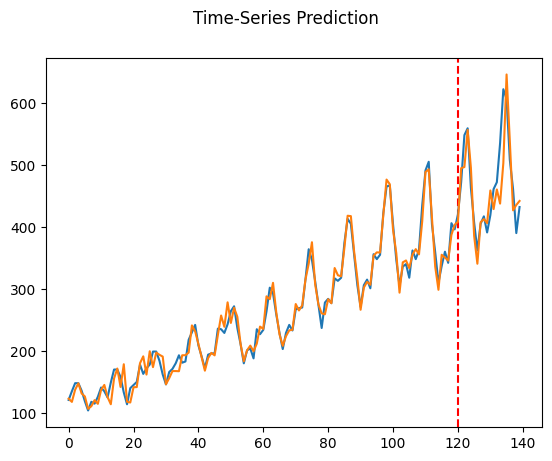

In [12]:
best_model.eval()
train_predict = best_model(dataX[:,:,0])

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

print("Best Loss: {}".format(best_loss))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()